## Applications to simulated data sets

In [1]:
# libraries
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def hmc(U, gradU, M, epsilon, m, theta, mh):
    """HMC with an optional Metropolis-Hastings test
    """
    # Resample momentum r
    r=np.random.normal(size=(np.size(theta),1))*np.sqrt(M)
    theta0=theta
    # Calculate the original energy for MH test
    E0=r.T * M * r/2+U(theta)
    
    # Simulate discretization of Hamiltonian dynamics
    for i in range(1,m+1):
        r=r-gradU(theta)*epsilon/2
        theta=theta+epsilon*r/M
        r=r-gradU(theta)*epsilon/2
    #r=-r
    
    #carry out MH test
    if mh:
        Enew=r.T * M * r/2+U(theta)

        if np.exp(E0-Enew)<np.random.uniform(0,1,(1,1)):
            theta=theta0

    newtheta=theta
    return newtheta

In [3]:
def sghmc(U,gradU,M,epsilon,m,theta,C,V):
    """SGHMC algorithm
    """
    
    # optionally, resample momentum r as
    r=np.random.standard_normal(size=(np.size(theta),1))*np.sqrt(M)
    Bhat=0.5*V*epsilon
    
    # simulate dynamics in Eq.(13) in the original paper
    for i in range(1,m+1):
        r=r-gradU(theta)*epsilon-r*C*epsilon+np.random.standard_normal(size=(1,1))*np.sqrt(2*(C-Bhat)*epsilon)
        theta=theta+(r/M)*epsilon
        
    newtheta=theta
    return newtheta

In [4]:
# parameters
# sample size is unknown based on the original paper
nsample = 10**5
theta_step = 0.1
m = 1
dt = 0.1
nstep = 50
np.random.seed(19860222)
theta_init = 0

theta_range = np.arange(-2, 2.01, step=theta_step)
C = 3
V = 4

# functions
U = lambda x: -2 * x**2 + x**4
gradUPerfect =  lambda theta: - 4 * theta +  4 * theta**3
noise = 2*np.random.randn(1)
gradU = lambda theta: -4 * theta + 4 * theta**3 + 2*np.random.randn(1)

In [5]:
## Standard HMC (with MH)

samples = np.zeros((nsample))
theta = theta_init
for i in range(nsample):
    theta = hmc( U, gradUPerfect, m, dt, nstep, theta, True)
    samples[i] = theta

freq_hmc_mh, theta = np.histogram(samples, theta_range)
freq_hmc_mh = freq_hmc_mh / sum(freq_hmc_mh) / theta_step

In [6]:
## Standard HMC (no MH)

samples = np.zeros((nsample))
theta = theta_init
for i in range(nsample):
    theta = hmc( U, gradUPerfect, m, dt, nstep, theta, False)
    samples[i] = theta

freq_hmc_nmh, theta = np.histogram(samples, theta_range)
freq_hmc_nmh = freq_hmc_nmh / sum(freq_hmc_nmh) / theta_step

In [7]:
## Naive stochastic gradient HMC (with MH)

samples = np.zeros((nsample))
theta = theta_init
for i in range(nsample):
    theta = hmc( U, gradU, m, dt, nstep, theta, True)
    samples[i] = theta

freq_nsghmc_mh, theta = np.histogram(samples, theta_range)
freq_nsghmc_mh = freq_nsghmc_mh / sum(freq_nsghmc_mh) / theta_step

In [8]:
## Naive stochastic gradient HMC (no MH)

samples = np.zeros((nsample))
theta = theta_init
for i in range(nsample):
    theta = hmc( U, gradU, m, dt, nstep, theta, False)
    samples[i] = theta

freq_nsghmc_nmh, theta = np.histogram(samples, theta_range)
freq_nsghmc_nmh = freq_nsghmc_nmh / sum(freq_nsghmc_nmh) / theta_step

In [9]:
## SGHMC

samples = np.zeros((nsample))
theta = theta_init
for i in range(nsample):
    theta = sghmc( U, gradU, m, dt, nstep, theta, C, V)
    samples[i] = theta

freq_sghmc, theta = np.histogram(samples, theta_range)
freq_sghmc = freq_sghmc / sum(freq_sghmc) / theta_step

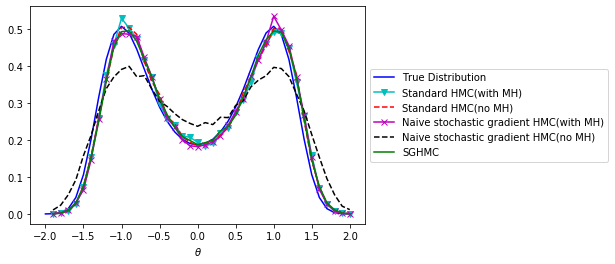

In [10]:
plt.figure()
freq_true = np.exp(-U(theta_range))
freq_true = freq_true / sum(freq_true) / theta_step

# Show the true distribution
plt.plot(theta_range, freq_true, color="b", label = 'True Distribution')
plt.plot(theta[1:], freq_hmc_mh, "c-v", label = 'Standard HMC(with MH)')
plt.plot(theta[1:], freq_hmc_nmh, "r--", label = 'Standard HMC(no MH)')
plt.plot(theta[1:], freq_nsghmc_mh, "m-x", label = 'Naive stochastic gradient HMC(with MH)')
plt.plot(theta[1:], freq_nsghmc_nmh, "k--", label = 'Naive stochastic gradient HMC(no MH)')
plt.plot(theta[1:], freq_sghmc, "g", label = 'SGHMC')
plt.xlabel(r"$\theta$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [11]:
def sghmc_2d(U, gradU, theta, m, nsteps, C, V, epsilon=0.1):
    
    B = V * epsilon / 2
    
    assert theta.shape[0] == 2
    D = np.linalg.cholesky(2*(C - B)*epsilon)
    
    r = np.random.randn(theta.shape[0])
    for i in range(nsteps):
        r = r - epsilon*gradU(theta) - epsilon*C@r - D@np.random.randn(theta.shape[0])
        theta = theta + epsilon * r
        
    return theta

In [12]:
# parameters
# sample size is unknown based on the original paper
nsample = 50
m = 1
dt = 0.1
nstep = 50
np.random.seed(19860222)
theta_init = np.array([0.,0.])

C = np.eye(2)
V = np.eye(2)

# functions
S = np.array([[1, 0.9], [0.9, 1]])
invS = np.linalg.inv(S)
U = lambda x: 0.5 * x.T @ invS @ x
gradUPerfect = lambda x: invS @ x
gradU = lambda x: invS @ x + np.random.randn(2)

In [13]:
sghmc_2d(U, gradU, theta_init, m, nstep, C, V)

array([-0.04914453,  0.90808981])

In [14]:
# gather samples using SGHMC
samples = np.empty((nsample, theta_init.shape[0]))

samples[0] = theta_init

for i in range(nsample - 1):
    theta = samples[i]
    theta = sghmc_2d(U, gradU, theta_init, m, nstep, C, V)
    samples[i+1] = theta
    
#samples   

In [15]:
f = lambda x: np.exp(-U(x))

theta_range = np.linspace(-2, 3, 100)
Theta0, Theta1 = np.meshgrid(theta_range, theta_range)

In [16]:
grids = np.vstack([Theta0.ravel(), Theta1.ravel()]).T

Z = []
for grid in grids:
    Z.append(f(grid))
    
Z = np.array(Z).reshape((100, 100))

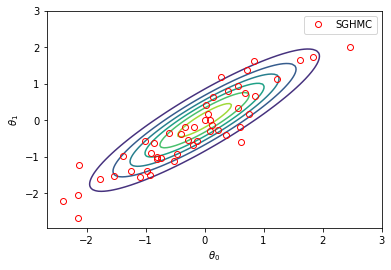

In [17]:
plt.contour(Theta0, Theta1, Z)
plt.plot(samples[:,0], samples[:,1], "ro", markerfacecolor="none", label="SGHMC")
plt.legend()
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
pass